In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Parámetros de la ecuación y de la simulación
alpha = 0.01  # Difusividad térmica
L = 1.0       # Longitud de la barra
T = 2.0       # Tiempo total de la simulación
nx = 100      # Número de puntos espaciales
nt = 5000     # Número de pasos temporales
dx = L / (nx - 1)  # Paso espacial
dt = T / nt   # Paso temporal
mu = L / 2
sigma = 0.07
x = np.linspace(0, L, nx)

In [ ]:
def gaussian_equation(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Condición inicial
tu = gaussian_equation(x, mu, sigma)

In [ ]:
# Red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, t):
        xt = torch.cat((x, t), dim=1)
        return self.net(xt)

In [ ]:
# Entrenamiento de la PINN
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# Generar puntos de entrenamiento
x = torch.rand(1000, 1, requires_grad=True)
t = torch.rand(1000, 1, requires_grad=True)

# Condiciones de frontera
x_boundary = torch.cat([torch.zeros(500, 1), torch.ones(500, 1)], dim=0)
t_boundary = torch.rand(1000, 1)
u_boundary = torch.zeros(1000, 1)  # Temperatura en las fronteras es 0

# Condición inicial
x_initial = torch.rand(500, 1)
t_initial = torch.zeros(500, 1)
u_initial = torch.tensor(gaussian_equation(x_initial.detach().numpy(), mu, sigma), dtype=torch.float32)

In [ ]:
for epoch in range(10000):
    optimizer.zero_grad()
    u_pred = model(x, t)

    # Derivadas usando autograd
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

    # Pérdida basada en la ecuación de calor
    loss_pde = criterion(u_t - alpha * u_xx, torch.zeros_like(u_t))
    loss_ic = criterion(model(x_initial, t_initial), u_initial)
    loss_bc = criterion(model(x_boundary, t_boundary), u_boundary)

    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 4.03371000289917
Epoch 1000, Loss: 0.013212260790169239
Epoch 2000, Loss: 0.002240533707663417
Epoch 3000, Loss: 0.0008949784678407013
Epoch 4000, Loss: 0.000474645261419937
Epoch 5000, Loss: 0.0002762614458333701
Epoch 6000, Loss: 0.00021242676302790642
Epoch 7000, Loss: 0.00013270124327391386
Epoch 8000, Loss: 0.00010638377716531977
Epoch 9000, Loss: 9.963224147213623e-05


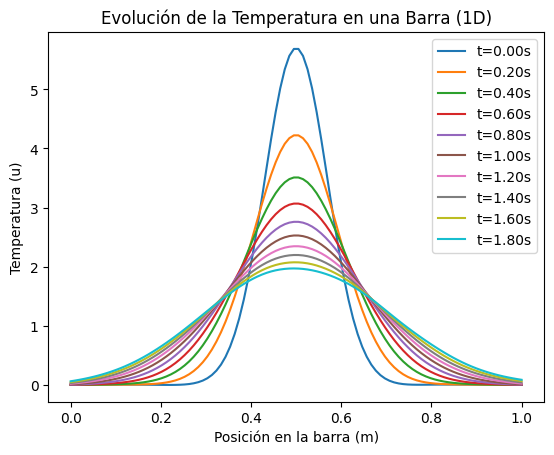

In [ ]:
x_plot = np.linspace(0, L, nx)
t_plot = np.linspace(0, T, nt)
U_pred_list = []
for i in range(nt):
    t_tensor = torch.full((nx, 1), t_plot[i], dtype=torch.float32)
    x_tensor = torch.from_numpy(x_plot.reshape(-1, 1)).float()
    U_pred_list.append(model(x_tensor, t_tensor).detach().numpy().flatten())

fig, ax = plt.subplots()
for i in range(0, nt, nt // 10):  # Mostramos 10 curvas a lo largo del tiempo
    ax.plot(x_plot, U_pred_list[i], label=f"t={i*dt:.2f}s")

ax.set_xlabel('Posición en la barra (m)')
ax.set_ylabel('Temperatura (u)')
ax.set_title('Evolución de la Temperatura en una Barra (1D)')
ax.legend()
plt.savefig('evol_temperatura_pinns.jpg')
plt.show()

In [ ]:
np.shape(U_pred_list)


(5000, 100)

In [ ]:
# Ntiempo=10

# Temp = np.repeat(u_hist[Ntiempo], 100).reshape(50, 100)
Lx=1
Ly=0.1
ny=100
x=np.linspace(0, Lx, nx)
y=np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x,y)

Temp = np.zeros((nt, nx, ny))
# Evolucion temporal , y construccion de la barra
for i in range(0, nt):
    Temp[i] = np.tile(U_pred_list[i].reshape(nx, 1), ny)

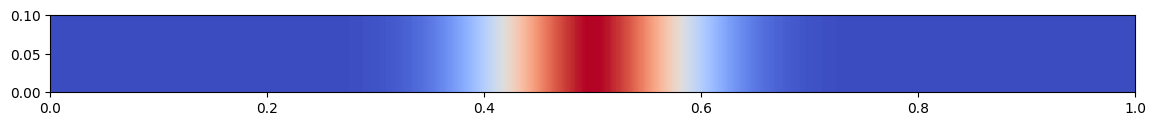

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
maxT = np.max(Temp)
fig, ax = plt.subplots(figsize=(14, 1))

contour = ax.contour(X, Y, Temp[0].T/maxT, 200, vmin=0, vmax=1, cmap='coolwarm')  # Actualizar con el nuevo frame
#ax.set_colorbar()
ax.set_xlabel('Posición en la barra (m)')
ax.set_ylabel('Ly')
ax.set_title('Evolución de la Temperatura en una Barra (1D)')

def update(frame):
    ax.clear()  # Limpiar el gráfico anterior
    contour = ax.contourf(X, Y, Temp[frame].T/maxT, 200, vmin=0, vmax=1, cmap='coolwarm')  # Actualizar con el nuevo frame
    return contour,


# Crear la animación con un intervalo mayor y repetir en False
ani = FuncAnimation(fig, update, frames=range(0, nt, 50), interval=100, repeat=False)
ani.save("mapa_calor_pinns.gif", writer=PillowWriter(fps=10))

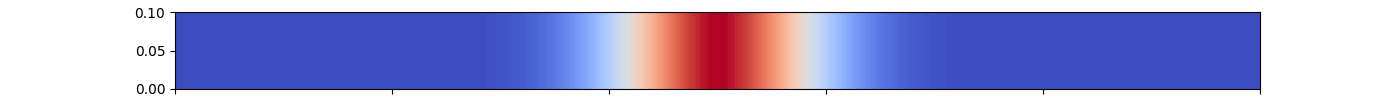

In [ ]:
from IPython.display import Image
Image(filename="mapa_calor_pinns.gif")

<ipython-input-13-8098c85556c8>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustar para dar espacio a la barra de color


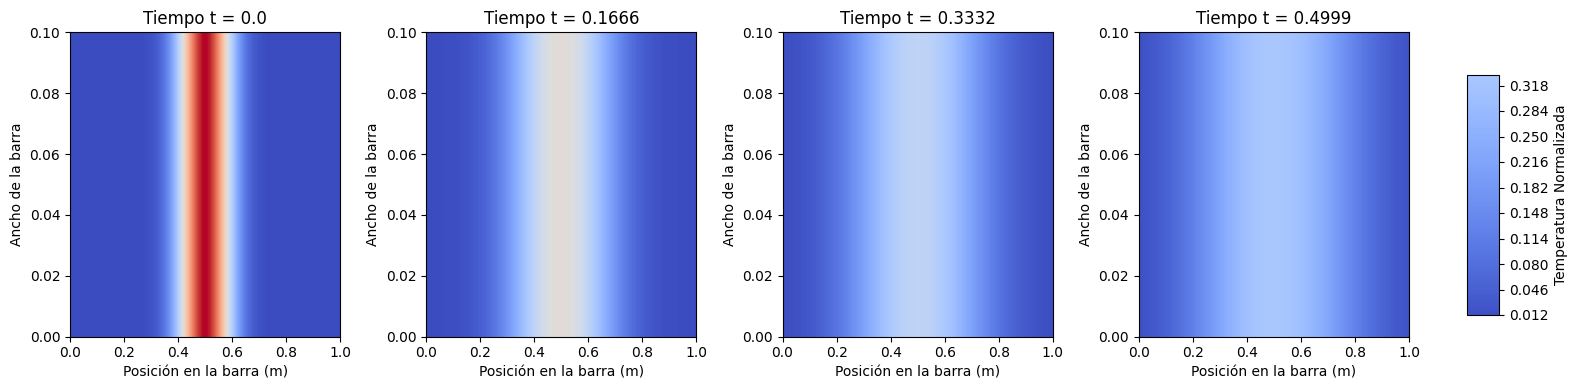

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que X, Y y Temp ya están definidos
maxT = np.max(Temp)
frames_to_plot = 4  # Número de frames a mostrar
timesteps = np.linspace(0, Temp.shape[0] - 1, frames_to_plot, dtype=int)  # Elegir 4 tiempos equidistantes

# Crear una figura con 1 fila y 4 columnas
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Crear un único mapa de colores para todas las imágenes
vmin, vmax = 0, 1  # Normalizar los valores

# Generar los 4 frames en la misma imagen
for i, ax in enumerate(axes.flat):  # `flat` convierte la matriz en lista
    t = timesteps[i]  # Tiempo actual del frame
    contour = ax.contourf(X, Y, Temp[t].T / maxT, 200, vmin=vmin, vmax=vmax, cmap='coolwarm')
    ax.set_title(f'Tiempo t = {t/10000}')
    ax.set_xlabel('Posición en la barra (m)')
    ax.set_ylabel('Ancho de la barra')

# Añadir una barra de color común para toda la figura
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Posición de la barra de color
fig.colorbar(contour, cax=cbar_ax, label='Temperatura Normalizada')

# Ajustar el espacio entre subgráficos
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustar para dar espacio a la barra de color

# Guardar la imagen final con los 4 frames
plt.savefig("mapa_evolucion_pinns.png", dpi=300, bbox_inches='tight')

# Mostrar la imagen
plt.show()

In [ ]:
# prompt: guardar los datos de U_pred_list como un archivo .npy

import numpy as np
np.save('U_pred_list.npy', U_pred_list)